In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import argparse
import os
import torch
from torch.autograd import Variable
from tqdm import tqdm
import time
from models.deep_isp_model import DenoisingNet
from msr_demosaic import MSRDemosaic
from audio_dataset import AudioDataset, AudioGenDataset
import deep_isp_utils as utils
from collections import OrderedDict
import shutil
import matplotlib.pyplot as plt
from loss import *
from datetime import datetime

import numpy as np
from torch import nn
import quantize
import actquant
import IPython.display as ipd


transformation = utils.JointCompose([
    utils.JointHorizontalFlip(),
    utils.JointVerticalFlip(),
    #utils.JointNormailze(means = [0.485,0.456,0.406],stds = [1,1,1]), #TODO consider use
    utils.JointToTensor(),
])
val_transformation = utils.JointCompose([
    #utils.JointNormailze(means = [0.485,0.456,0.406],stds = [1,1,1]),
    utils.JointToTensor(),
])

Here we put the parameters of the model

In [2]:
num_denoise_layers = 20
quant = False
inject_noise = False
quant_bitwidth = 32
quant_epoch_step = 50
inject_act_noise = False
act_bitwidth = 32
act_quant = False
quant_start_stage = 0
weight_relu = False
weight_grad_after_quant = False
random_inject_noise = False
step = 19
num_workers = 1
wrpn = False

gpus = [0]

The function ```load model``` loads a .tar file from a pretrained model

In [3]:
def load_model(model,checkpoint):

    new_state_dict = OrderedDict()
    for k, v in checkpoint['state_dict'].items():
        name = k[7:] if k[0:6] == 'module.' else k # remove `module. if needed (happen when the model created with DataParallel
        #new_state_dict[name] = v
        new_state_dict[name] = v if v.dim() > 1 or 'num_batches_tracked' in name else v*v.new_ones(1)

    # load params
    model.load_state_dict(new_state_dict, strict=False) #strict false in case the loaded doesn't have alll variables like running mean


In [4]:
model = DenoisingNet(in_channels=1, num_denoise_layers=num_denoise_layers, quant=quant , noise=inject_noise, bitwidth=quant_bitwidth, quant_epoch_step=quant_epoch_step,
                         act_noise=inject_act_noise , act_bitwidth= act_bitwidth , act_quant=act_quant, use_cuda=(gpus is not None), quant_start_stage=quant_start_stage,
                         weight_relu=weight_relu, weight_grad_after_quant=weight_grad_after_quant, random_inject_noise = random_inject_noise
                         , step=step, wrpn=wrpn)
model.cuda()
device = 'cuda:' + str(0)
torch.cuda.set_device(0)

checkpoint_file = "/home/simon/denoise/Denoising-drone-rotors/output/2019-05-17_11-31-44/checkpoint.pth.tar" # checkpoint location
if os.path.isfile(checkpoint_file):
    print("loading checkpoint {}".format(checkpoint_file))
    checkpoint = torch.load(checkpoint_file, map_location=device)
    load_model(model, checkpoint)
    

/home/simon/denoise/Denoising-drone-rotors/models/deep_isp_model.py:53: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, mode='fan_out')
/home/simon/denoise/Denoising-drone-rotors/models/deep_isp_model.py:55: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


loading checkpoint /home/simon/denoise/Denoising-drone-rotors/output/2019-05-17_11-31-44/checkpoint.pth.tar


In [5]:
# Load dataset

# datapath = '/home/simon/denoise/dataset/data/data.h5'
# testset = MSRDemosaic(root=datapath, train=False, transform=val_transformation)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=num_workers)

# use train set to check overfitting
# testset = AudioDataset(data_h5_path=datapath, train=True)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=num_workers)

trainset = AudioGenDataset("/home/simon/denoise/dataset/generator/")
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=num_workers)


# testset = AudioDataset(data_h5_path=datapath, train=False)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=num_workers)


  0%|          | 0/90 [00:00<?, ?it/s]

data source
data shape: (513, 87)
3.5277808


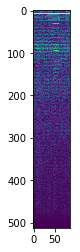

target
max:  3.5949838
min:  7.906474e-06


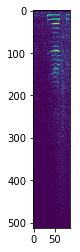

torch.Size([1, 1, 513, 87])
output
3.8095381
-0.13215941


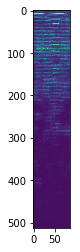

  1%|          | 1/90 [00:06<09:26,  6.36s/it]

data source
data shape: (513, 87)
4.087992


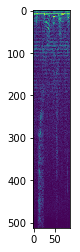

target
max:  4.647762
min:  5.9815335e-05


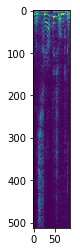

torch.Size([1, 1, 513, 87])
output
4.6284447
-0.31589407


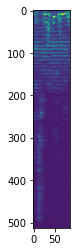

  2%|▏         | 2/90 [00:12<09:17,  6.33s/it]

data source
data shape: (513, 87)
2.7461898


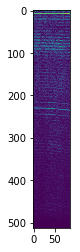

target
max:  2.0903208
min:  3.0837941e-06


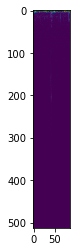

torch.Size([1, 1, 513, 87])
output
2.6140242
-0.085517466


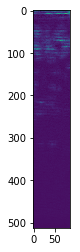

  3%|▎         | 3/90 [00:18<09:09,  6.32s/it]

data source
data shape: (513, 87)
3.3485262


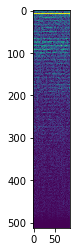

target
max:  2.5378623
min:  2.8206458e-05


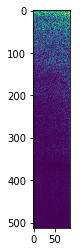

torch.Size([1, 1, 513, 87])
output
3.081877
-0.07417086


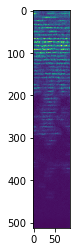

  4%|▍         | 4/90 [00:25<09:02,  6.31s/it]

data source
data shape: (513, 87)
2.8881588


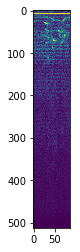

target
max:  3.4700506
min:  1.1121214e-06


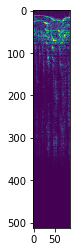

torch.Size([1, 1, 513, 87])
output
3.6060908
-0.061035484


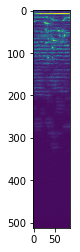

  6%|▌         | 5/90 [00:31<08:52,  6.26s/it]

data source
data shape: (513, 87)
2.9709442


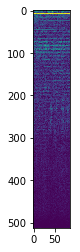

target
max:  3.0760534
min:  4.6538706e-05


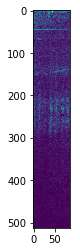

torch.Size([1, 1, 513, 87])
output
2.6467824
-0.13018546


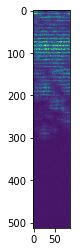

  7%|▋         | 6/90 [00:37<08:46,  6.27s/it]

data source
data shape: (513, 87)
3.567283


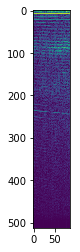

target
max:  3.544538
min:  6.250026e-05


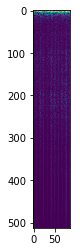

torch.Size([1, 1, 513, 87])
output
3.5505393
-0.17355752


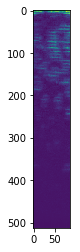

  8%|▊         | 7/90 [00:43<08:39,  6.25s/it]

data source
data shape: (513, 87)
3.8358085


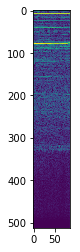

target
max:  4.4970145
min:  2.8462723e-06


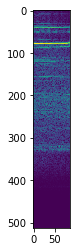

torch.Size([1, 1, 513, 87])
output
4.311243
-0.06778461


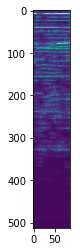

  9%|▉         | 8/90 [00:50<08:33,  6.26s/it]

data source
data shape: (513, 87)
3.298098


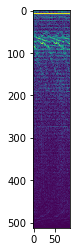

target
max:  3.6389437
min:  9.306119e-05


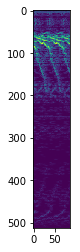

torch.Size([1, 1, 513, 87])
output
3.852065
-0.038553894


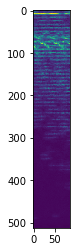

 10%|█         | 9/90 [00:56<08:27,  6.26s/it]

data source
data shape: (513, 87)
3.7413847


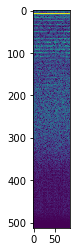

target
max:  2.5862572
min:  8.829378e-08


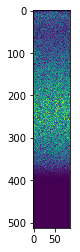

torch.Size([1, 1, 513, 87])
output
3.937472
-0.21478528


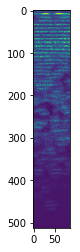

 11%|█         | 10/90 [01:02<08:20,  6.26s/it]

data source
data shape: (513, 87)
4.389146


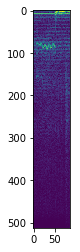

target
max:  5.071052
min:  1.0034157e-08


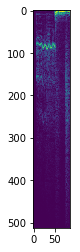

torch.Size([1, 1, 513, 87])
output
4.9753838
-0.03342606


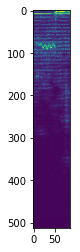

 12%|█▏        | 11/90 [01:09<08:17,  6.29s/it]

data source
data shape: (513, 87)
3.8439958


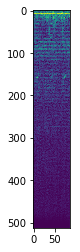

target
max:  3.715918
min:  1.0211914e-07


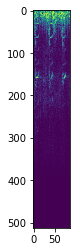

torch.Size([1, 1, 513, 87])
output
3.712684
-0.09239743


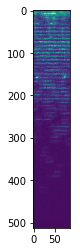

 13%|█▎        | 12/90 [01:15<08:09,  6.28s/it]

data source
data shape: (513, 87)
3.589689


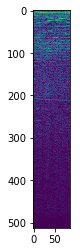

target
max:  3.2822518
min:  4.4004908e-05


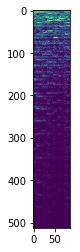

torch.Size([1, 1, 513, 87])
output
3.1015294
-0.29618144


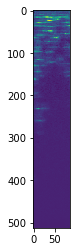

 14%|█▍        | 13/90 [01:21<08:02,  6.26s/it]

data source
data shape: (513, 87)
3.2750347


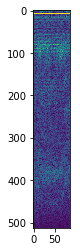

target
max:  3.0543354
min:  0.0003035127


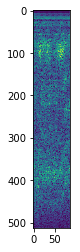

torch.Size([1, 1, 513, 87])
output
3.8056865
-0.16376866


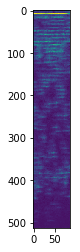

 16%|█▌        | 14/90 [01:27<07:54,  6.25s/it]

data source
data shape: (513, 87)
3.4204586


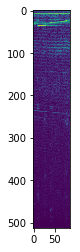

target
max:  4.1067104
min:  3.9512106e-06


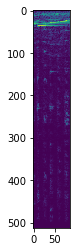

torch.Size([1, 1, 513, 87])
output
4.069847
-0.15435104


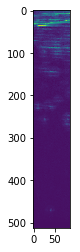

 17%|█▋        | 15/90 [01:33<07:48,  6.25s/it]

data source
data shape: (513, 87)
3.6645179


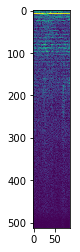

target
max:  3.9010968
min:  0.00012924393


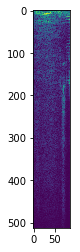

torch.Size([1, 1, 513, 87])
output
3.2869349
-0.116352975


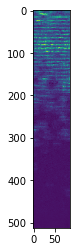

 18%|█▊        | 16/90 [01:40<07:43,  6.26s/it]

data source
data shape: (513, 87)
3.253985


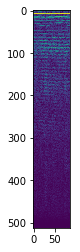

target
max:  3.0203674
min:  4.8297725e-06


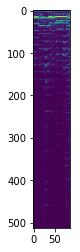

Process Process-1:
Traceback (most recent call last):
  File "/home/simon/anaconda3/envs/denoise/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/simon/anaconda3/envs/denoise/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/simon/anaconda3/envs/denoise/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/simon/anaconda3/envs/denoise/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/simon/anaconda3/envs/denoise/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/simon/anaconda3/envs/denoise/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/simon/anaconda3/envs/denoise/lib/python3.7/multiprocessin

KeyboardInterrupt: 

In [6]:
import IPython.display as ipd
from preprocess_audio.preprocess_audio import *
# convert back to audio
from preprocess_audio.postprocess_audio import *

test_loader = train_loader

# ipd.Audio('/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav')
# ipd.Audio(x, rate=sr) # load a NumPy array

def unbias_image(img):
    return  torch.clamp(img, 0 , 1.).data.squeeze(0).cpu().numpy()#.transpose(1, 2, 0) + 0.5  #the clamp is becuase the value should be between 0-1


# Run inference
loader = test_loader
N_CHANNELS = 513
N_FFT = 1024
fs = 22050
n = 5

# create_spectogram
# def read_audio_spectum(filename):
#     x, fs = librosa.load(filename)
#     S = librosa.stft(x, N_FFT)
#     p = np.angle(S)
#     return np.log1p(np.abs(S[np.newaxis,:,:1000])), fs

# a_content, fs = read_audio_spectum("/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav")
# N_SAMPLES = a_content.shape[2]
# N_CHANNELS = a_content.shape[1]
# # a_style = a_style[:, :N_CHANNELS, :N_SAMPLES]

# t = np.zeros_like(a_content)
# a = np.zeros_like(a_content[0])
# a[:N_CHANNELS,:] = np.exp(t[0]) - 1

# # This code is supposed to do phase reconstruction
# p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
# for i in range(500):
#     S = a * np.exp(1j*p)
#     x = librosa.istft(S)
#     p = np.angle(librosa.stft(x, N_FFT))

# librosa.output.write_wav("/home/simon/denoise/dataset/audio/file_example_WAV_1MG_re.wav", x, fs)
# ipd.Audio(x, rate=fs) # load a NumPy array
def to_image(data):
    return data.data.cpu().squeeze(0).squeeze(0).numpy()

for batch_idx, (data, target, fname) in enumerate(tqdm(loader)):
    
    # display noisy sample
    plt.figure()
    print("data source")
    data_image = to_image(data)
    print("data shape:", data_image.shape)
    print(data_image.max())
    plt.imshow(data_image, interpolation='nearest')
    plt.show()
    y = spectogram_to_wav(data_image, N_CHANNELS, N_FFT, fs, dst_path='/home/simon/denoise/dataset/data/orig_{}.wav'.format(batch_idx))
    ipd.display(ipd.Audio(y, rate=fs)) # load a NumPy array
    
    # display target sample
    print("target")
    target_image = to_image(target)
    print("max: ", target_image.max())
    print("min: ", target_image.min())
    plt.imshow(target_image, interpolation='nearest')
    plt.show()
    t = spectogram_to_wav(target_image, N_CHANNELS, N_FFT, fs, dst_path='/home/simon/denoise/dataset/data/target_{}.wav'.format(batch_idx))
    ipd.display(ipd.Audio(t, rate=fs)) # load a NumPy array

    # infer noisy sample
    if gpus is not None:
        data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)

    with torch.no_grad():
        data, target = Variable(data), Variable(target)
        
    print(data.shape)
    output = model(data)
#     output *= 1.0 / output.max()
#     output = torch.sigmoid(output)
#     np_output = unbias_image(output).squeeze(0)
    np_output = to_image(output)
    # display infered sample
    print("output")
    print(np_output.max())
    print(np_output.min())
    plt.imshow(np_output, interpolation='nearest')
    plt.show()
    dst_file_path = '/home/simon/denoise/dataset/data/test_{}.wav'.format(batch_idx)
    x = spectogram_to_wav(np_output, N_CHANNELS, N_FFT, fs, dst_path=None)
    ipd.display(ipd.Audio(x, rate=fs))


In [ ]:
# ipd.Audio(x, rate=fs) # load a NumPy array
ipd.Audio(y, rate=fs) # load a NumPy array

In [ ]:
audio_sample_file_path = '/home/simon/denoise/dataset/audio/file_example_WAV_1MG.wav'
ipd.Audio(audio_sample_file_path) # load a local WAV file

# convert to spectogram
N_FFT = 1024
sound_audio, fs = librosa.load(audio_sample_file_path)
spectogram_sound_label, N_CHANNELS = create_spectogram(sound_audio, N_FFT)
print("from create_spectogram shape: ", spectogram_sound_label.shape)

# convert back to audio
from preprocess_audio.postprocess_audio import *


# hf = h5py.File('/home/simon/denoise/dataset/data/data.h5', 'r')
# train = hf.get('train')
# input = train.get('input')
# train_input_list = list(input.keys())
# # print(train_input_list)
# specto = np.array(input.get(train_input_list[0]))
# print("specto shape: ", specto.shape)
# x = spectogram_to_wav(specto, 513, 1024, 22050)
# print(x.shape)
# hf.close()

x = spectogram_to_wav(spectogram_sound_label, N_CHANNELS, N_FFT, fs)
ipd.Audio(x, rate=fs) # load a local WAV file
